In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import random
from torch.autograd import Variable


In [2]:
batch_size = 64
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#difine transforms
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# define the data loaders
data_loader = DataLoader(datasets.MNIST('', train=True, transform=transform),batch_size=batch_size, shuffle=True)

In [4]:
image, classe = random.choice(data_loader.dataset)
print(classe)
transforms.ToPILImage()(image)

1


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.emb = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [7]:
def noise(batch_size):
    z = Variable(torch.randn(batch_size, 100))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
    return z, fake_labels

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [9]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [10]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z, fake_labels = noise(batch_size)
    z = z.to(device)
    fake_labels = fake_labels.to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [11]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    z, fake_labels = noise(batch_size)
    z = z.to(device)
    fake_labels = fake_labels.to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [12]:
def show_images(generator, monitoring_noise):
    z = monitoring_noise[0].to(device)
    labels = monitoring_noise[1].to(device)
    with torch.no_grad():
        monitoring_generated_images = generator(z, labels).to("cpu")
    for image in monitoring_generated_images:
        
        display(transforms.ToPILImage()(image))

In [13]:
# generate a noise to monitor the model improvement
monitoring_noise = noise(5)

In [16]:
num_epochs = 70
history = {"d_loss":[], "g_loss":[]}
for epoch in range(num_epochs):
    d_loss = 0
    g_loss = 0
    print('Starting epoch {}...'.format(epoch), end=' ')
    for i, (images, labels) in enumerate(data_loader):
        
        
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()
        
        d_loss += discriminator_train_step(len(real_images), discriminator, generator, d_optimizer, criterion, real_images, labels)
        g_loss += generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        
        
    history["d_loss"].append(d_loss/i)
    history["g_loss"].append(g_loss/i)
    print('discriminator loss: {}'.format(d_loss/i), end=' ')
    print('generator loss: {}'.format(g_loss/i), end=' ')
    print('Done!')
    if epoch % 5 == 0:
        print(f"Epoch {epoch}")
        show_images(generator, monitoring_noise)
print("training is complete")

Starting epoch 0... discriminator loss: 0.30604757629374685 generator loss: 4.1128123615696435 Done!
Epoch 0


Starting epoch 1... discriminator loss: 0.3441344565267624 generator loss: 3.956169777771452 Done!
Starting epoch 2... discriminator loss: 0.365717915048785 generator loss: 3.6946696965391634 Done!
Starting epoch 3... discriminator loss: 0.3943603440260429 generator loss: 3.547191303720342 Done!
Starting epoch 4... discriminator loss: 0.4824022511089879 generator loss: 3.1559659984348425 Done!
Starting epoch 5... discriminator loss: 0.513792467775696 generator loss: 2.8123711448087256 Done!
Epoch 5


Starting epoch 6... discriminator loss: 0.532764052679979 generator loss: 2.7766286184337376 Done!
Starting epoch 7... discriminator loss: 0.5493534779535922 generator loss: 2.7524402038519256 Done!
Starting epoch 8... discriminator loss: 0.5904196513500641 generator loss: 2.5761169285504515 Done!
Starting epoch 9... discriminator loss: 0.6392463743368615 generator loss: 2.407691645647698 Done!
Starting epoch 10... discriminator loss: 0.7094247475377778 generator loss: 2.1689629112007522 Done!
Epoch 10


Starting epoch 11... discriminator loss: 0.7161479078972735 generator loss: 2.1320947051175505 Done!
Starting epoch 12... discriminator loss: 0.7318683895446447 generator loss: 2.066334228759896 Done!
Starting epoch 13... discriminator loss: 0.7928781764166333 generator loss: 1.951635192908752 Done!
Starting epoch 14... discriminator loss: 0.8291129821965127 generator loss: 1.811254266104805 Done!
Starting epoch 15... discriminator loss: 0.8211556369619665 generator loss: 1.8278918628249885 Done!
Epoch 15


Starting epoch 16... discriminator loss: 0.8446178108676393 generator loss: 1.7705379788114777 Done!
Starting epoch 17... discriminator loss: 0.8864555340439176 generator loss: 1.6793252454241667 Done!
Starting epoch 18... discriminator loss: 0.9052197644397568 generator loss: 1.6577671253566681 Done!
Starting epoch 19... discriminator loss: 0.9282252354072278 generator loss: 1.5671119372516458 Done!
Starting epoch 20... discriminator loss: 0.9432892349639086 generator loss: 1.553966688244676 Done!
Epoch 20


Starting epoch 21... discriminator loss: 0.9497053551317661 generator loss: 1.5164368713042016 Done!
Starting epoch 22... discriminator loss: 0.9700393045088525 generator loss: 1.488413073209968 Done!
Starting epoch 23... discriminator loss: 1.0137497420117594 generator loss: 1.3884674843118439 Done!
Starting epoch 24... discriminator loss: 1.0266279251242143 generator loss: 1.3774895118420254 Done!
Starting epoch 25... discriminator loss: 1.035048488618979 generator loss: 1.3427224696763933 Done!
Epoch 25


Starting epoch 26... discriminator loss: 1.0365149334884123 generator loss: 1.3466083101427289 Done!
Starting epoch 27... discriminator loss: 1.0592332648365832 generator loss: 1.2791835645983034 Done!
Starting epoch 28... discriminator loss: 1.096849135108284 generator loss: 1.22836395770534 Done!
Starting epoch 29... discriminator loss: 1.098580274154435 generator loss: 1.2101796308856383 Done!
Starting epoch 30... discriminator loss: 1.1140131551529835 generator loss: 1.1914240563310197 Done!
Epoch 30


Starting epoch 31... discriminator loss: 1.1220676525552602 generator loss: 1.166844158378711 Done!
Starting epoch 32... discriminator loss: 1.1275227298222585 generator loss: 1.1781506428341983 Done!
Starting epoch 33... discriminator loss: 1.1377334215597765 generator loss: 1.1298797596226124 Done!
Starting epoch 34... discriminator loss: 1.145903375767084 generator loss: 1.130282857692865 Done!
Starting epoch 35... discriminator loss: 1.1509500427078156 generator loss: 1.1003656508192308 Done!
Epoch 35


Starting epoch 36... discriminator loss: 1.1585960825835628 generator loss: 1.1168837035223922 Done!
Starting epoch 37... discriminator loss: 1.1654976507770087 generator loss: 1.076880881091701 Done!
Starting epoch 38... discriminator loss: 1.1734165562000702 generator loss: 1.092282808895681 Done!
Starting epoch 39... discriminator loss: 1.165546788858884 generator loss: 1.0735771820792013 Done!
Starting epoch 40... discriminator loss: 1.1844442009671394 generator loss: 1.0499478204527686 Done!
Epoch 40


Starting epoch 41... discriminator loss: 1.186283269012496 generator loss: 1.0508459741557803 Done!
Starting epoch 42... discriminator loss: 1.1927035805255397 generator loss: 1.034419039524734 Done!
Starting epoch 43... discriminator loss: 1.2017226532785463 generator loss: 1.0147777706098404 Done!
Starting epoch 44... discriminator loss: 1.203386860634245 generator loss: 1.0166457383838763 Done!
Starting epoch 45... discriminator loss: 1.2070118106162153 generator loss: 1.0019309074799814 Done!
Epoch 45


Starting epoch 46... discriminator loss: 1.2137779019049417 generator loss: 0.9994136694910177 Done!
Starting epoch 47... discriminator loss: 1.2292361633500268 generator loss: 0.9644948824874365 Done!
Starting epoch 48... discriminator loss: 1.2241346857082118 generator loss: 0.9774186503034773 Done!
Starting epoch 49... discriminator loss: 1.2334266380668322 generator loss: 0.960406414218239 Done!
Starting epoch 50... discriminator loss: 1.2287280868695156 generator loss: 0.9764159734628244 Done!
Epoch 50


Starting epoch 51... discriminator loss: 1.2337273151286765 generator loss: 0.9566594173966757 Done!
Starting epoch 52... discriminator loss: 1.2357296873691115 generator loss: 0.9599850105883091 Done!
Starting epoch 53... discriminator loss: 1.2420801335236051 generator loss: 0.9509521182089757 Done!
Starting epoch 54... discriminator loss: 1.2470293779128898 generator loss: 0.9336983451466677 Done!
Starting epoch 55... discriminator loss: 1.2444845156837554 generator loss: 0.9389623477975485 Done!
Epoch 55


Starting epoch 56... discriminator loss: 1.2459500511529733 generator loss: 0.9393814695937402 Done!
Starting epoch 57... discriminator loss: 1.2480181456884427 generator loss: 0.9364114125739295 Done!
Starting epoch 58... discriminator loss: 1.2605273363557161 generator loss: 0.9189609214106899 Done!
Starting epoch 59... discriminator loss: 1.2509976685237987 generator loss: 0.9318582841146463 Done!
Starting epoch 60... discriminator loss: 1.2511244003393607 generator loss: 0.9318287103509445 Done!
Epoch 60


Starting epoch 61... discriminator loss: 1.2648524403444859 generator loss: 0.911954634472044 Done!
Starting epoch 62... discriminator loss: 1.2614371425441389 generator loss: 0.9091419176841622 Done!
Starting epoch 63... discriminator loss: 1.2626933342873605 generator loss: 0.9141807720271856 Done!
Starting epoch 64... discriminator loss: 1.2684103789935117 generator loss: 0.8958058921479111 Done!
Starting epoch 65... discriminator loss: 1.2792518418779242 generator loss: 0.8805185714806156 Done!
Epoch 65


Starting epoch 66... discriminator loss: 1.2792000930871628 generator loss: 0.8923932325369266 Done!
Starting epoch 67... discriminator loss: 1.269613687867416 generator loss: 0.9014686767166936 Done!
Starting epoch 68... discriminator loss: 1.2776701932528485 generator loss: 0.8932802735677778 Done!
Starting epoch 69... discriminator loss: 1.2782498893259429 generator loss: 0.8854516302508758 Done!
training is complete


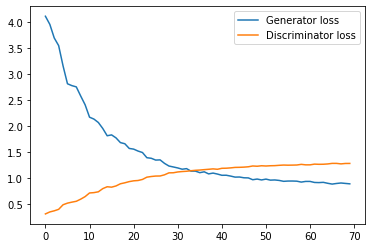

In [17]:
#plot loss
plt.figure()
plt.plot(history["g_loss"], label='Generator loss')
plt.plot(history["d_loss"], label='Discriminator loss')
plt.legend()
plt.savefig('loss1.png')
plt.show()

In [18]:
torch.save(generator.state_dict(), 'mnist_generatorLast.pt')